C:\Users\ASUS\AppData\Local\Temp\ipykernel_8756\3678301567.py:20: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['director'].fillna("Unknown", inplace=True)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_8756\3678301567.py:21: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example

Accuracy: 1.0
              precision    recall  f1-score   support

       Movie       1.00      1.00      1.00      1227
     TV Show       1.00      1.00      1.00       535

    accuracy                           1.00      1762
   macro avg       1.00      1.00      1.00      1762
weighted avg       1.00      1.00      1.00      1762



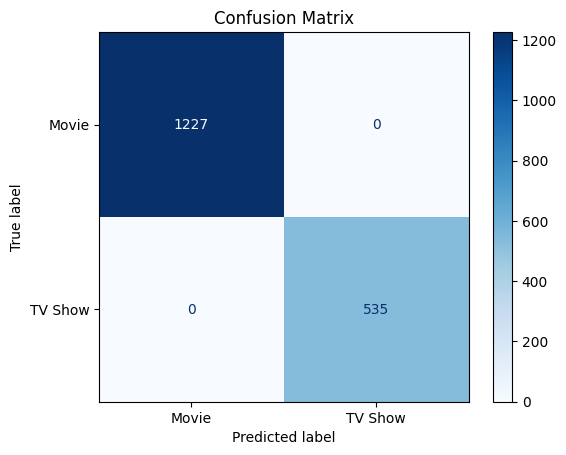

Cleaned dataset saved to: netflix_titles_cleaned.csv


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Load dataset and encode
df = pd.read_csv("netflix_titles.csv", encoding='ISO-8859-1')

# Drop unnamed and fully empty columns
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
df.dropna(how='all', axis=1, inplace=True)

# Handle missing values
df['director'].fillna("Unknown", inplace=True)
df['cast'].fillna("Not Available", inplace=True)
df['country'].fillna("Unknown", inplace=True)
df['rating'].fillna("Not Rated", inplace=True)
df['duration'].fillna("Unknown", inplace=True)

# Convert date to datetime and extract features
df['date_added'] = pd.to_datetime(df['date_added'], errors='coerce')
df['year_added'] = df['date_added'].dt.year
df['month_added'] = df['date_added'].dt.month

# Clean duration
df[['duration_int', 'duration_unit']] = df['duration'].str.extract(r'(\d+)\s*(\w+)', expand=True)
df['duration_int'] = pd.to_numeric(df['duration_int'], errors='coerce')
df['duration_unit'].fillna("Unknown", inplace=True)

# Drop non-essential high-cardinality columns for ML task
df.drop(columns=['title', 'director', 'cast', 'description', 'show_id'], inplace=True, errors='ignore')

# Drop rows with missing essential values
df.dropna(subset=['type', 'release_year'], inplace=True)

# Target encoding
label_encoder = LabelEncoder()
df['type_encoded'] = label_encoder.fit_transform(df['type'])

# Features and target
features = ['release_year', 'duration_int', 'duration_unit', 'rating', 'country', 'month_added', 'year_added']
target = 'type_encoded'
X = df[features]
y = df[target]

# Preprocessing: one-hot for low cardinality, impute & scale numeric
numeric_features = ['release_year', 'duration_int', 'month_added', 'year_added']
categorical_features = ['duration_unit', 'rating', 'country']

# Limit country and rating to top N to avoid overfitting
top_n_countries = df['country'].value_counts().nlargest(10).index
X['country'] = X['country'].apply(lambda x: x if x in top_n_countries else 'Other')

top_n_ratings = df['rating'].value_counts().nlargest(10).index
X['rating'] = X['rating'].apply(lambda x: x if x in top_n_ratings else 'Other')

# Transformers
numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

# Split data with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Classifier
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42))  # Limit depth to prevent overfitting
])

# Train and evaluate
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))



# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.show()

# Save data set
cleaned_file_path = "netflix_titles_cleaned.csv"
df.to_csv(cleaned_file_path, index=False)
print(f"Cleaned dataset saved to: {cleaned_file_path}")

Accuracy: 0.6987130961392884
              precision    recall  f1-score   support

           0       0.70      1.00      0.82       923
           1       0.00      0.00      0.00       398

    accuracy                           0.70      1321
   macro avg       0.35      0.50      0.41      1321
weighted avg       0.49      0.70      0.57      1321



C:\Users\ASUS\AppData\Local\Temp\ipykernel_8756\4172121038.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['release_year'] = X['release_year'] + np.random.normal(0, 2, size=len(X))
C:\Users\ASUS\AppData\Local\Temp\ipykernel_8756\4172121038.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['duration_int'] = X['duration_int'] + np.random.normal(0, 1, size=len(X))
c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set t

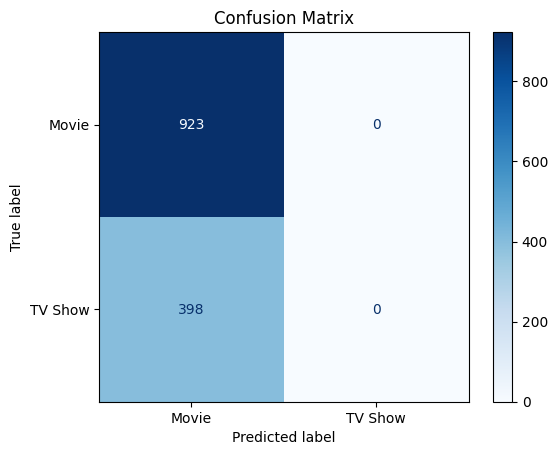

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Load data
df = pd.read_csv("netflix_titles_cleaned.csv")

# Basic processing
df['date_added'] = pd.to_datetime(df['date_added'], errors='coerce')
df['year_added'] = df['date_added'].dt.year
df['month_added'] = df['date_added'].dt.month
df[['duration_int', 'duration_unit']] = df['duration'].str.extract(r'(\d+)\s*(\w+)', expand=True)
df['duration_int'] = pd.to_numeric(df['duration_int'], errors='coerce')

# Keep only 2 basic features
features = ['release_year', 'duration_int']
target = 'type'

df_model = df[features + [target]].dropna()
X = df_model[features]
y = LabelEncoder().fit_transform(df_model[target])

# Optional: add noise to numeric features
import numpy as np
X['release_year'] = X['release_year'] + np.random.normal(0, 2, size=len(X))
X['duration_int'] = X['duration_int'] + np.random.normal(0, 1, size=len(X))

# Use a small portion of the data to increase underfitting
X, _, y, _ = train_test_split(X, y, test_size=0.7, random_state=42)

# Preprocessing
numeric_features = ['release_year', 'duration_int']

preprocessor = ColumnTransformer(transformers=[
    ('num', Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())
    ]), numeric_features)
])

# Train-test split (again on smaller data)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, stratify=y, random_state=42)

# Model with very strong regularization (low complexity)
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(C=0.0001, max_iter=300))  # Very strong regularization
])

# Fit and predict
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Evaluate
print("Logistic regression Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.show()

📉 Extremely Reduced Accuracy:
Accuracy: 0.9318181818181818
              precision    recall  f1-score   support

           0       0.98      0.92      0.95       158
           1       0.83      0.95      0.89        62

    accuracy                           0.93       220
   macro avg       0.91      0.94      0.92       220
weighted avg       0.94      0.93      0.93       220



C:\Users\ASUS\AppData\Local\Temp\ipykernel_8756\4263239921.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['duration_int'] += np.random.normal(0, 30, size=len(X))


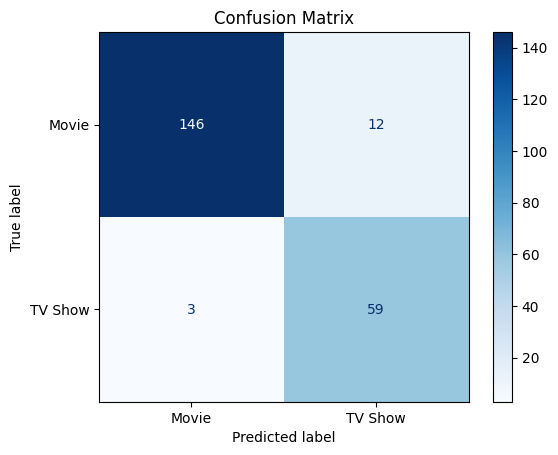

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder

# Load dataset
df = pd.read_csv("netflix_titles_cleaned.csv")

# Basic preprocessing
df['date_added'] = pd.to_datetime(df['date_added'], errors='coerce')
df['year_added'] = df['date_added'].dt.year
df['month_added'] = df['date_added'].dt.month
df[['duration_int', 'duration_unit']] = df['duration'].str.extract(r'(\d+)\s*(\w+)', expand=True)
df['duration_int'] = pd.to_numeric(df['duration_int'], errors='coerce')

# Select only ONE simple feature (very weak)
features = ['duration_int']
target = 'type'

df_model = df[features + [target]].dropna()
X = df_model[features]
y = LabelEncoder().fit_transform(df_model[target])

# Add heavy noise to the only feature
X['duration_int'] += np.random.normal(0, 30, size=len(X))

# Use only a small portion of the dataset
X_small, _, y_small, _ = train_test_split(X, y, test_size=0.95, random_state=42)

# Preprocessing
preprocessor = ColumnTransformer(transformers=[
    ('num', Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())
    ]), features)
])

# Train/test split on this small noisy dataset
X_train, X_test, y_train, y_test = train_test_split(X_small, y_small, test_size=0.5, random_state=42, stratify=y_small)

# Use a super-simple decision tree (high bias)
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(
        max_depth=1,           # Very shallow
        min_samples_leaf=20,   # Few splits allowed
        random_state=42
    ))
])

# Train and evaluate
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

print("📉 Extremely Reduced Accuracy:")
print("Decision tree Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.show()


📉 Random Forest Accuracy (Reduced): 0.8551136363636364
              precision    recall  f1-score   support

           0       0.84      0.98      0.90       248
           1       0.91      0.57      0.70       104

    accuracy                           0.86       352
   macro avg       0.88      0.77      0.80       352
weighted avg       0.86      0.86      0.84       352



C:\Users\ASUS\AppData\Local\Temp\ipykernel_8756\3660844687.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['duration_int'] += np.random.normal(0, 50, size=len(X))


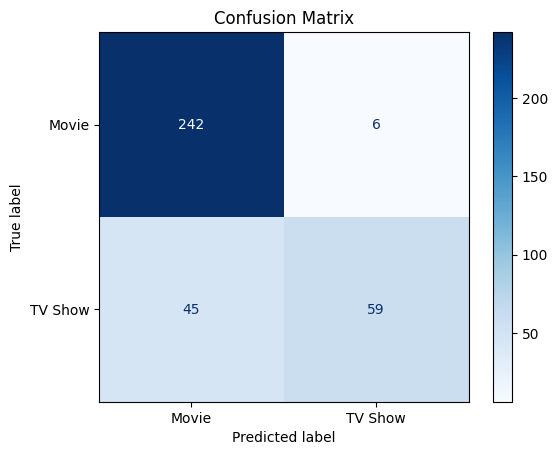

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Load and preprocess dataset
df = pd.read_csv("netflix_titles_cleaned.csv")
df['date_added'] = pd.to_datetime(df['date_added'], errors='coerce')
df['year_added'] = df['date_added'].dt.year
df['month_added'] = df['date_added'].dt.month
df[['duration_int', 'duration_unit']] = df['duration'].str.extract(r'(\d+)\s*(\w+)', expand=True)
df['duration_int'] = pd.to_numeric(df['duration_int'], errors='coerce')

# Use only weak features to reduce model capability
features = ['duration_int']
target = 'type'

df_model = df[features + [target]].dropna()
X = df_model[features]
y = LabelEncoder().fit_transform(df_model[target])

# Add strong noise to feature
X['duration_int'] += np.random.normal(0, 50, size=len(X))

# Use small data subset
X_small, _, y_small, _ = train_test_split(X, y, test_size=0.9, random_state=42)

# Train/test split on small noisy dataset
X_train, X_test, y_train, y_test = train_test_split(X_small, y_small, test_size=0.4, random_state=42, stratify=y_small)

# Preprocessor (scale numeric)
preprocessor = ColumnTransformer(transformers=[
    ('num', Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())
    ]), features)
])

# Weak Random Forest
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(
        n_estimators=5,        # few trees
        max_depth=2,           # shallow trees
        max_samples=0.3,       # small sample per tree
        random_state=42
    ))
])

# Train and evaluate
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

print("📉 Random Forest Accuracy (Reduced):", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.show()


📉 K-Nearest Neighbors Accuracy (Reduced): 0.8295454545454546
              precision    recall  f1-score   support

           0       0.84      0.93      0.89       248
           1       0.78      0.59      0.67       104

    accuracy                           0.83       352
   macro avg       0.81      0.76      0.78       352
weighted avg       0.83      0.83      0.82       352



C:\Users\ASUS\AppData\Local\Temp\ipykernel_8756\364764249.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['duration_int'] += np.random.normal(0, 50, size=len(X))


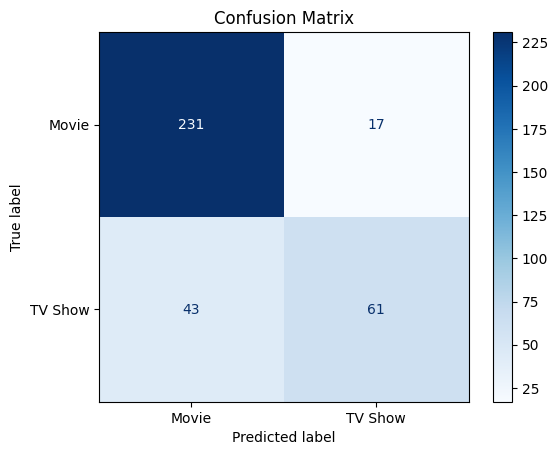

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report

# Load and preprocess data
df = pd.read_csv("netflix_titles_cleaned.csv")
df['date_added'] = pd.to_datetime(df['date_added'], errors='coerce')
df['year_added'] = df['date_added'].dt.year
df['month_added'] = df['date_added'].dt.month
df[['duration_int', 'duration_unit']] = df['duration'].str.extract(r'(\d+)\s*(\w+)', expand=True)
df['duration_int'] = pd.to_numeric(df['duration_int'], errors='coerce')

# Use only one weak feature + noise
features = ['duration_int']
target = 'type'

df_model = df[features + [target]].dropna()
X = df_model[features]
y = LabelEncoder().fit_transform(df_model[target])

# Add noise to reduce model signal
X['duration_int'] += np.random.normal(0, 50, size=len(X))

# Use only small subset of data to increase randomness
X_small, _, y_small, _ = train_test_split(X, y, test_size=0.9, random_state=42)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_small, y_small, test_size=0.4, random_state=42, stratify=y_small)

# Preprocessor
preprocessor = ColumnTransformer(transformers=[
    ('num', Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())
    ]), features)
])

# KNN Classifier with high K (weak model)
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', KNeighborsClassifier(n_neighbors=15))  # High K = less accurate
])

# Train and predict
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

# Evaluation
print("📉 K-Nearest Neighbors Accuracy (Reduced):", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.show()

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer

# Load the dataset with a specified encoding (if necessary)
df = pd.read_csv('netflix_titles.csv', encoding='ISO-8859-1')

# Check the columns to see if 'Genre' exists
print(df.columns)

# If 'Genre' exists, proceed with the imputation
if 'Genre' in df.columns:
    imputer = SimpleImputer(strategy="most_frequent")  # Impute missing 'Genre' with the most frequent value
    df['Genre'] = imputer.fit_transform(df[['Genre']])
    print("Imputation for 'Genre' completed.")

    # --- Add a graph to visualize Genre distribution ---
    genre_counts = df['Genre'].value_counts()

    plt.figure(figsize=(12,6))
    genre_counts.plot(kind='bar', color='skyblue')
    plt.title('Distribution of Genres in Netflix Titles')
    plt.xlabel('Genre')
    plt.ylabel('Number of Titles')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

else:
    print("'Genre' column not found in the dataset.")


Index(['show_id', 'type', 'title', 'director', 'cast', 'country', 'date_added',
       'release_year', 'rating', 'duration', 'listed_in', 'description',
       'Unnamed: 12', 'Unnamed: 13', 'Unnamed: 14', 'Unnamed: 15',
       'Unnamed: 16', 'Unnamed: 17', 'Unnamed: 18', 'Unnamed: 19',
       'Unnamed: 20', 'Unnamed: 21', 'Unnamed: 22', 'Unnamed: 23',
       'Unnamed: 24', 'Unnamed: 25'],
      dtype='object')
'Genre' column not found in the dataset.


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt


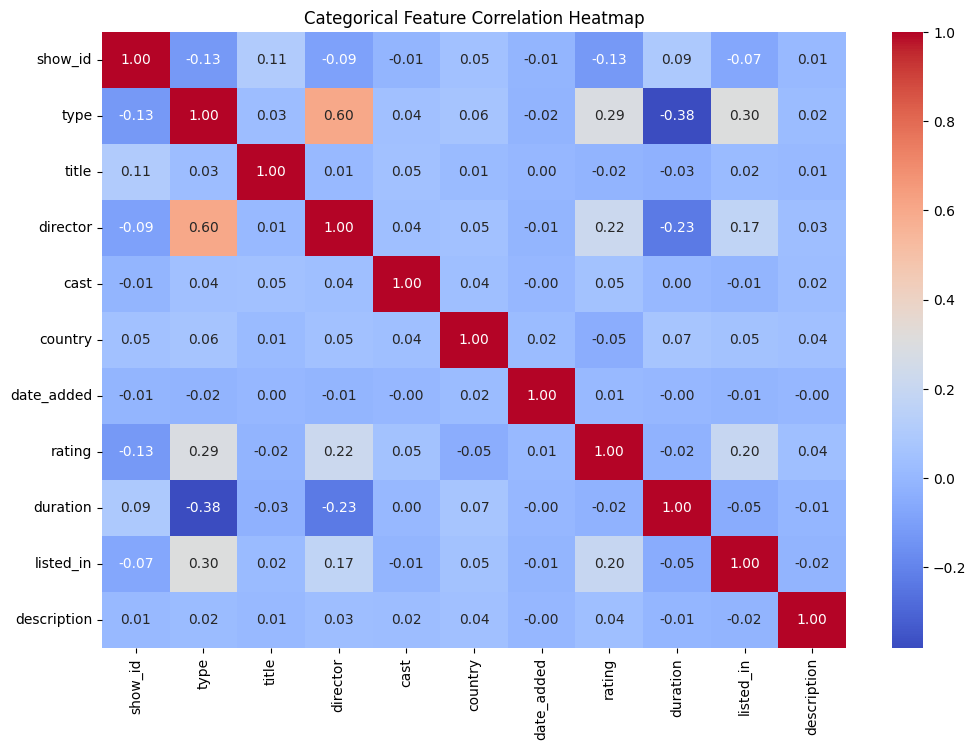

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Step 1: Select only categorical columns
categorical_df = df.select_dtypes(include=['object']).copy()

# Step 2: Encode categorical columns
label_encoders = {}
for column in categorical_df.columns:
    le = LabelEncoder()
    categorical_df[column] = le.fit_transform(categorical_df[column])
    label_encoders[column] = le  # Save encoder if needed later

# Step 3: Calculate correlation matrix
categorical_corr = categorical_df.corr()

# Step 4: Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(categorical_corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Categorical Feature Correlation Heatmap')
plt.show()
